In [1]:
# =============================================================================
# 1. SETUP & INSTALLATION
# =============================================================================

print("🔧 Setting up environment...")

# Install required packages
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
!pip install onnx onnxruntime onnxruntime-tools
!pip install kaggle pandas numpy matplotlib seaborn scikit-learn
!pip install opencv-python pillow tqdm

import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import cv2
from PIL import Image
import json
from datetime import datetime

# Deep Learning imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import torchvision.models as models

# ONNX imports
import onnx
import onnxruntime as ort

print("✅ Environment setup completed!")
print(f"PyTorch version: {torch.__version__}")
print(f"ONNX Runtime version: {ort.__version__}")

🔧 Setting up environment...
Looking in indexes: https://download.pytorch.org/whl/cpu
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 40.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 63.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.7/212.7 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 5.3 MB/s eta 0:00:00
✅ Environment setup completed!
PyTorch version: 2.8.0+cu126
ONNX Runtime version: 1.23.2


In [7]:
# =============================================================================
# 2. KAGGLE DATASET SETUP
# =============================================================================

print("\n📥 Setting up Kaggle dataset...")

# Create kaggle directory and configure
os.makedirs('/root/.kaggle', exist_ok=True)

# Copy kaggle.json from Colab upload to proper location
import shutil
shutil.copy('/content/kaggle.json', '/root/.kaggle/kaggle.json')
os.chmod('/root/.kaggle/kaggle.json', 0o600)

# Download garbage classification dataset
print("Downloading dataset...")
!kaggle datasets download -d mostafaabla/garbage-classification -p /content/unsople_data/

# Extract dataset
print("Extracting dataset...")
!unzip -q /content/unsople_data/garbage-classification.zip -d /content/unsople_data/

# Verify dataset structure
# Find the actual directory created by unzip
extracted_dirs = [d for d in os.listdir('/content/unsople_data/') if os.path.isdir(os.path.join('/content/unsople_data/', d))]
if extracted_dirs:
    # Assuming the dataset is in the first extracted directory
    dataset_path = os.path.join('/content/unsople_data/', extracted_dirs[0])
else:
    raise FileNotFoundError("Could not find the extracted dataset directory.")

print(f"\n📁 Dataset location: {dataset_path}")

# List classes
classes = os.listdir(dataset_path)
print(f"🎯 Classes found: {classes}")

# Count images per class
class_counts = {}
for class_name in classes:
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        class_counts[class_name] = len(os.listdir(class_path))

print("\n📊 Dataset Statistics:")
for class_name, count in class_counts.items():
    print(f"  {class_name}: {count} images")


📥 Setting up Kaggle dataset...
Dataset URL: https://www.kaggle.com/datasets/mostafaabla/garbage-classification
License(s): ODbL-1.0
garbage-classification.zip: Skipping, found more recently modified local copy (use --force to force download)
Extracting dataset...
replace /content/unsople_data/garbage_classification/battery/battery1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A

📁 Dataset location: /content/unsople_data/garbage_classification
🎯 Classes found: ['green-glass', 'metal', 'biological', 'white-glass', 'clothes', 'brown-glass', 'battery', 'trash', 'shoes', 'plastic', 'cardboard', 'paper']

📊 Dataset Statistics:
  green-glass: 629 images
  metal: 769 images
  biological: 985 images
  white-glass: 775 images
  clothes: 5325 images
  brown-glass: 607 images
  battery: 945 images
  trash: 697 images
  shoes: 1977 images
  plastic: 865 images
  cardboard: 891 images
  paper: 1050 images



📊 Preparing dataset...
✅ Dataset prepared!
📚 Training samples: 12412
📚 Validation samples: 3103
🎯 Number of classes: 12

📸 Sample images from dataset:


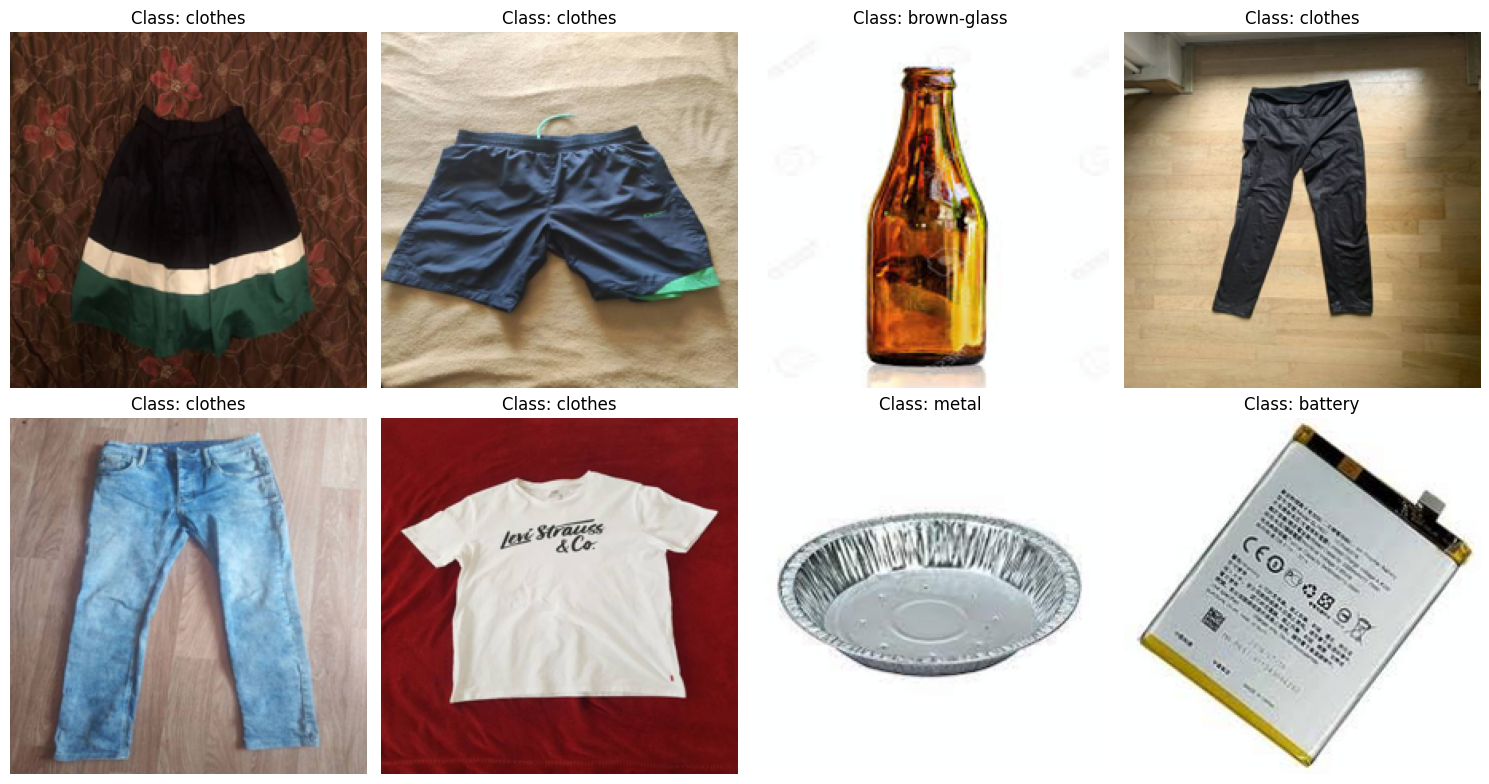

In [8]:
# =============================================================================
# 3. DATA PREPARATION & VISUALIZATION
# =============================================================================

print("\n📊 Preparing dataset...")

# Define Unsople waste categories mapping
UNSOPLE_CLASSES = {
    'plastic': ['plastic'],
    'paper': ['paper', 'cardboard'],
    'organic': ['organic'],
    'metal': ['metal'],
    'glass': ['glass']
}

# Custom dataset class
class WasteDataset(Dataset):
    def __init__(self, root_dir, transform=None, target_size=(224, 224)):
        self.root_dir = root_dir
        self.transform = transform
        self.target_size = target_size
        self.images = []
        self.labels = []
        self.class_to_idx = {}
        self.idx_to_class = {}

        # Build class mapping
        all_classes = sorted(os.listdir(root_dir))
        for idx, class_name in enumerate(all_classes):
            self.class_to_idx[class_name] = idx
            self.idx_to_class[idx] = class_name

        # Load images and labels
        for class_name in all_classes:
            class_path = os.path.join(root_dir, class_name)
            if os.path.isdir(class_path):
                for img_name in os.listdir(class_path):
                    if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                        self.images.append(os.path.join(class_path, img_name))
                        self.labels.append(self.class_to_idx[class_name])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]

        # Load image
        image = Image.open(img_path).convert('RGB')

        # Resize image
        image = image.resize(self.target_size)

        if self.transform:
            image = self.transform(image)
        else:
            # Default transform to tensor
            image = transforms.ToTensor()(image)

        return image, label

# Data transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(0.3),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create dataset
full_dataset = WasteDataset(dataset_path, transform=train_transform)

# Split dataset (80% train, 20% validation)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Apply validation transform to val dataset
val_dataset.dataset.transform = val_transform

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"✅ Dataset prepared!")
print(f"📚 Training samples: {len(train_dataset)}")
print(f"📚 Validation samples: {len(val_dataset)}")
print(f"🎯 Number of classes: {len(full_dataset.class_to_idx)}")

# Visualize sample images
def visualize_samples(dataset, num_samples=8):
    fig, axes = plt.subplots(2, 4, figsize=(15, 8))
    axes = axes.ravel()

    for i in range(num_samples):
        img, label = dataset[i]
        img = img.permute(1, 2, 0).numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)

        axes[i].imshow(img)
        axes[i].set_title(f"Class: {dataset.dataset.idx_to_class[label]}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

print("\n📸 Sample images from dataset:")
visualize_samples(train_dataset)

In [9]:
# =============================================================================
# 4. MODEL DEFINITION
# =============================================================================

print("\n🧠 Creating Unsople AI Model...")

class UnsopleWasteClassifier(nn.Module):
    def __init__(self, num_classes=5, model_name='mobilenet_v2'):
        super(UnsopleWasteClassifier, self).__init__()

        if model_name == 'mobilenet_v2':
            self.backbone = models.mobilenet_v2(pretrained=True)
            # Replace classifier
            self.backbone.classifier[1] = nn.Linear(self.backbone.last_channel, num_classes)
        elif model_name == 'efficientnet_b0':
            self.backbone = models.efficientnet_b0(pretrained=True)
            self.backbone.classifier[1] = nn.Linear(self.backbone.classifier[1].in_features, num_classes)
        else:
            raise ValueError("Unsupported model name")

        self.model_name = model_name

    def forward(self, x):
        return self.backbone(x)

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Using device: {device}")

model = UnsopleWasteClassifier(num_classes=len(full_dataset.class_to_idx), model_name='mobilenet_v2')
model = model.to(device)

# Model summary
print(f"✅ Model created: {model.model_name}")
print(f"📊 Number of classes: {len(full_dataset.class_to_idx)}")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



🧠 Creating Unsople AI Model...
🚀 Using device: cuda
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 149MB/s]


✅ Model created: mobilenet_v2
📊 Number of classes: 12


In [10]:
# =============================================================================
# 5. TRAINING CONFIGURATION
# =============================================================================

print("\n⚙️ Setting up training configuration...")

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Training parameters
num_epochs = 15
best_accuracy = 0.0
training_history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

print("✅ Training configuration completed!")
print(f"📈 Number of epochs: {num_epochs}")
print(f"💡 Optimizer: Adam")
print(f"📉 Learning rate scheduler: StepLR")


⚙️ Setting up training configuration...
✅ Training configuration completed!
📈 Number of epochs: 15
💡 Optimizer: Adam
📉 Learning rate scheduler: StepLR


In [11]:
# =============================================================================
# 6. TRAINING LOOP
# =============================================================================

print("\n🎯 Starting Model Training...")

def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(dataloader, desc='Training')
    for batch_idx, (images, labels) in enumerate(pbar):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        pbar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'Acc': f'{100.*correct/total:.2f}%'
        })

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        pbar = tqdm(dataloader, desc='Validation')
        for batch_idx, (images, labels) in enumerate(pbar):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{100.*correct/total:.2f}%'
            })

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

# Training loop
for epoch in range(num_epochs):
    print(f'\n📍 Epoch {epoch+1}/{num_epochs}')
    print('-' * 50)

    # Training phase
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

    # Validation phase
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)

    # Update scheduler
    scheduler.step()

    # Save history
    training_history['train_loss'].append(train_loss)
    training_history['val_loss'].append(val_loss)
    training_history['train_acc'].append(train_acc)
    training_history['val_acc'].append(val_acc)

    print(f'📊 Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'📊 Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

    # Save best model
    if val_acc > best_accuracy:
        best_accuracy = val_acc
        torch.save(model.state_dict(), '/content/unsople_best_model.pth')
        print(f'💾 New best model saved! Accuracy: {val_acc:.2f}%')

print(f"\n✅ Training completed! Best validation accuracy: {best_accuracy:.2f}%")


🎯 Starting Model Training...

📍 Epoch 1/15
--------------------------------------------------


Validation: 100%|██████████| 97/97 [00:12<00:00,  7.61it/s, Loss=0.6174, Acc=87.27%]


📊 Train Loss: 0.6021, Train Acc: 81.35%
📊 Val Loss: 0.3864, Val Acc: 87.27%
💾 New best model saved! Accuracy: 87.27%

📍 Epoch 2/15
--------------------------------------------------


Validation: 100%|██████████| 97/97 [00:12<00:00,  7.87it/s, Loss=0.5958, Acc=88.50%]


📊 Train Loss: 0.3615, Train Acc: 88.53%
📊 Val Loss: 0.3429, Val Acc: 88.50%
💾 New best model saved! Accuracy: 88.50%

📍 Epoch 3/15
--------------------------------------------------


Validation: 100%|██████████| 97/97 [00:12<00:00,  7.86it/s, Loss=0.2909, Acc=91.17%]


📊 Train Loss: 0.3137, Train Acc: 89.99%
📊 Val Loss: 0.2855, Val Acc: 91.17%
💾 New best model saved! Accuracy: 91.17%

📍 Epoch 4/15
--------------------------------------------------


Validation: 100%|██████████| 97/97 [00:13<00:00,  6.97it/s, Loss=0.4637, Acc=89.62%]


📊 Train Loss: 0.2498, Train Acc: 92.27%
📊 Val Loss: 0.3469, Val Acc: 89.62%

📍 Epoch 5/15
--------------------------------------------------


Validation: 100%|██████████| 97/97 [00:12<00:00,  7.83it/s, Loss=0.3706, Acc=91.88%]


📊 Train Loss: 0.2267, Train Acc: 92.52%
📊 Val Loss: 0.2553, Val Acc: 91.88%
💾 New best model saved! Accuracy: 91.88%

📍 Epoch 6/15
--------------------------------------------------


Validation: 100%|██████████| 97/97 [00:12<00:00,  7.80it/s, Loss=0.6717, Acc=85.63%]


📊 Train Loss: 0.2151, Train Acc: 92.90%
📊 Val Loss: 0.4995, Val Acc: 85.63%

📍 Epoch 7/15
--------------------------------------------------


Validation: 100%|██████████| 97/97 [00:12<00:00,  7.91it/s, Loss=0.4511, Acc=91.30%]


📊 Train Loss: 0.1917, Train Acc: 93.74%
📊 Val Loss: 0.2924, Val Acc: 91.30%

📍 Epoch 8/15
--------------------------------------------------


Validation: 100%|██████████| 97/97 [00:12<00:00,  7.84it/s, Loss=0.2240, Acc=95.04%]


📊 Train Loss: 0.0770, Train Acc: 97.79%
📊 Val Loss: 0.1576, Val Acc: 95.04%
💾 New best model saved! Accuracy: 95.04%

📍 Epoch 9/15
--------------------------------------------------


Validation: 100%|██████████| 97/97 [00:12<00:00,  7.87it/s, Loss=0.2573, Acc=95.36%]


📊 Train Loss: 0.0409, Train Acc: 98.94%
📊 Val Loss: 0.1488, Val Acc: 95.36%
💾 New best model saved! Accuracy: 95.36%

📍 Epoch 10/15
--------------------------------------------------


Validation: 100%|██████████| 97/97 [00:12<00:00,  7.92it/s, Loss=0.2263, Acc=95.42%]


📊 Train Loss: 0.0267, Train Acc: 99.30%
📊 Val Loss: 0.1477, Val Acc: 95.42%
💾 New best model saved! Accuracy: 95.42%

📍 Epoch 11/15
--------------------------------------------------


Validation: 100%|██████████| 97/97 [00:12<00:00,  7.79it/s, Loss=0.2274, Acc=95.58%]


📊 Train Loss: 0.0195, Train Acc: 99.56%
📊 Val Loss: 0.1513, Val Acc: 95.58%
💾 New best model saved! Accuracy: 95.58%

📍 Epoch 12/15
--------------------------------------------------


Validation: 100%|██████████| 97/97 [00:12<00:00,  7.92it/s, Loss=0.1946, Acc=95.78%]


📊 Train Loss: 0.0150, Train Acc: 99.70%
📊 Val Loss: 0.1516, Val Acc: 95.78%
💾 New best model saved! Accuracy: 95.78%

📍 Epoch 13/15
--------------------------------------------------


Validation: 100%|██████████| 97/97 [00:12<00:00,  7.85it/s, Loss=0.2132, Acc=95.42%]


📊 Train Loss: 0.0139, Train Acc: 99.73%
📊 Val Loss: 0.1529, Val Acc: 95.42%

📍 Epoch 14/15
--------------------------------------------------


Validation: 100%|██████████| 97/97 [00:12<00:00,  7.74it/s, Loss=0.2522, Acc=95.97%]


📊 Train Loss: 0.0103, Train Acc: 99.81%
📊 Val Loss: 0.1495, Val Acc: 95.97%
💾 New best model saved! Accuracy: 95.97%

📍 Epoch 15/15
--------------------------------------------------


Validation: 100%|██████████| 97/97 [00:12<00:00,  7.62it/s, Loss=0.1944, Acc=96.04%]

📊 Train Loss: 0.0082, Train Acc: 99.86%
📊 Val Loss: 0.1463, Val Acc: 96.04%
💾 New best model saved! Accuracy: 96.04%

✅ Training completed! Best validation accuracy: 96.04%



📈 Plotting training history...


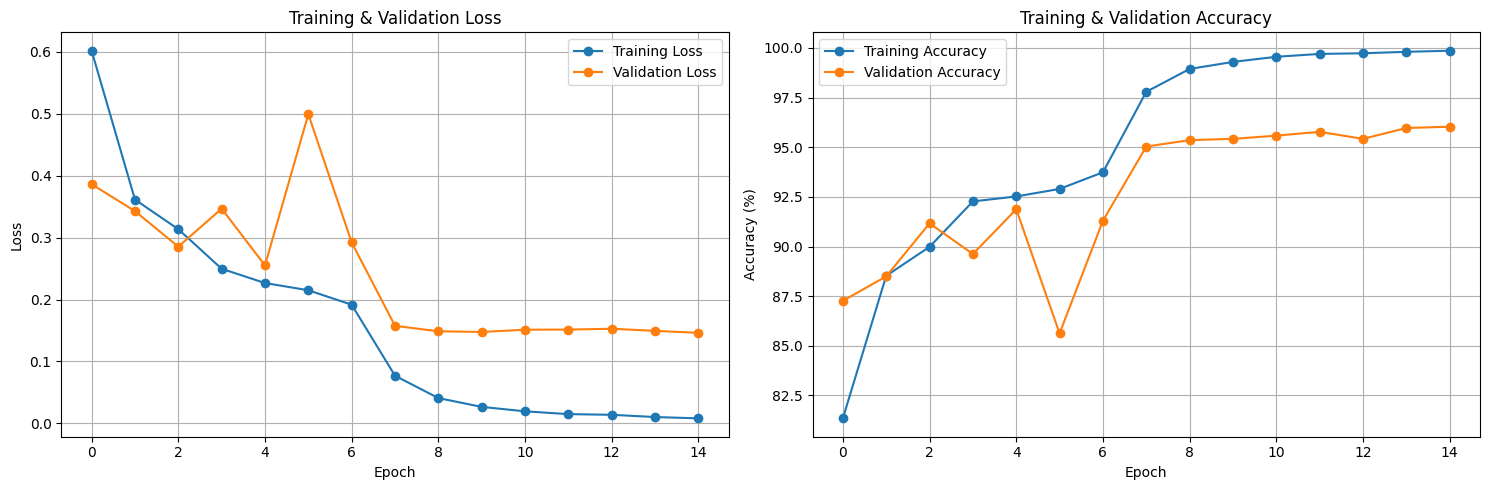

In [12]:
# =============================================================================
# 7. TRAINING VISUALIZATION
# =============================================================================

print("\n📈 Plotting training history...")

# Create plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
ax1.plot(training_history['train_loss'], label='Training Loss', marker='o')
ax1.plot(training_history['val_loss'], label='Validation Loss', marker='o')
ax1.set_title('Training & Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Accuracy plot
ax2.plot(training_history['train_acc'], label='Training Accuracy', marker='o')
ax2.plot(training_history['val_acc'], label='Validation Accuracy', marker='o')
ax2.set_title('Training & Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.savefig('/content/unsople_training_history.png', dpi=300, bbox_inches='tight')
plt.show()



📊 Evaluating model performance...


Evaluating: 100%|██████████| 97/97 [00:12<00:00,  7.99it/s]



📋 Classification Report:
              precision    recall  f1-score   support

     battery     0.9137    0.9524    0.9326       189
  biological     0.9659    0.9754    0.9706       203
 brown-glass     0.9250    0.9569    0.9407       116
   cardboard     0.9483    0.9593    0.9538       172
     clothes     0.9953    0.9906    0.9930      1068
 green-glass     0.9920    0.9466    0.9688       131
       metal     0.9507    0.8882    0.9184       152
       paper     0.9517    0.9704    0.9610       203
     plastic     0.9012    0.8690    0.8848       168
       shoes     0.9538    0.9751    0.9643       402
       trash     0.9645    0.9315    0.9477       146
 white-glass     0.8846    0.9020    0.8932       153

    accuracy                         0.9604      3103
   macro avg     0.9456    0.9431    0.9441      3103
weighted avg     0.9606    0.9604    0.9603      3103



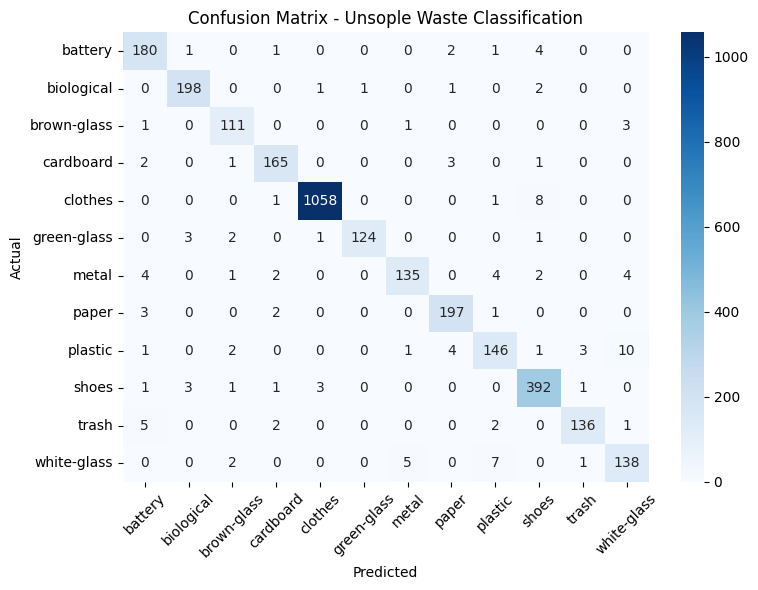

In [13]:
# =============================================================================
# 8. MODEL EVALUATION
# =============================================================================

print("\n📊 Evaluating model performance...")

from sklearn.metrics import classification_report, confusion_matrix

def evaluate_model(model, dataloader, device, class_names):
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc='Evaluating'):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_predictions, all_labels

# Get predictions
predictions, true_labels = evaluate_model(model, val_loader, device, list(full_dataset.class_to_idx.keys()))

# Classification report
print("\n📋 Classification Report:")
print(classification_report(true_labels, predictions,
                          target_names=list(full_dataset.class_to_idx.keys()),
                          digits=4))

# Confusion matrix
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(full_dataset.class_to_idx.keys()),
            yticklabels=list(full_dataset.class_to_idx.keys()))
plt.title('Confusion Matrix - Unsople Waste Classification')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('/content/unsople_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

In [14]:
# =============================================================================
# 9. EXPORT TO ONNX
# =============================================================================

print("\n📤 Exporting model to ONNX format...")

# Load best model for export
model.load_state_dict(torch.load('/content/unsople_best_model.pth'))
model.eval()

# Create dummy input
dummy_input = torch.randn(1, 3, 224, 224).to(device)

# Export to ONNX
onnx_model_path = "/content/unsople_waste_classifier.onnx"
torch.onnx.export(
    model,
    dummy_input,
    onnx_model_path,
    export_params=True,
    opset_version=12,
    input_names=['input'],
    output_names=['output'],
    dynamic_axes={
        'input': {0: 'batch_size'},
        'output': {0: 'batch_size'}
    }
)

print(f"✅ Model exported to: {onnx_model_path}")

# Verify ONNX model
onnx_model = onnx.load(onnx_model_path)
onnx.checker.check_model(onnx_model)
print("✅ ONNX model verification passed!")

# Test ONNX model with ONNX Runtime
ort_session = ort.InferenceSession(onnx_model_path)

# Test with dummy input
ort_inputs = {ort_session.get_inputs()[0].name: dummy_input.cpu().numpy()}
ort_outs = ort_session.run(None, ort_inputs)

print("✅ ONNX Runtime test completed!")
print(f"📊 Output shape: {ort_outs[0].shape}")


📤 Exporting model to ONNX format...


/tmp/ipython-input-1548208588.py:16: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(


✅ Model exported to: /content/unsople_waste_classifier.onnx
✅ ONNX model verification passed!
✅ ONNX Runtime test completed!
📊 Output shape: (1, 12)


In [15]:
# =============================================================================
# 10. MODEL METADATA & CONFIG
# =============================================================================

print("\n📝 Generating model metadata...")

# Create model configuration
model_config = {
    "model_name": "Unsople Waste Classifier",
    "version": "1.0.0",
    "description": "AI-powered waste classification for smart sorting system",
    "classes": full_dataset.idx_to_class,
    "class_to_idx": full_dataset.class_to_idx,
    "input_size": [224, 224],
    "mean": [0.485, 0.456, 0.406],
    "std": [0.229, 0.224, 0.225],
    "training_accuracy": float(best_accuracy),
    "export_date": datetime.now().isoformat(),
    "framework": "PyTorch",
    "onnx_opset": 12
}

# Save model configuration
config_path = "/content/unsople_model_config.json"
with open(config_path, 'w') as f:
    json.dump(model_config, f, indent=2)

print(f"✅ Model configuration saved to: {config_path}")


📝 Generating model metadata...
✅ Model configuration saved to: /content/unsople_model_config.json


In [16]:
# =============================================================================
# 11. FINAL VALIDATION
# =============================================================================

print("\n🔍 Final validation with sample images...")

def predict_single_image(image_path, model_path, class_names, transform):
    """Predict a single image using ONNX model"""
    # Load and preprocess image
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).numpy()

    # Run inference
    ort_session = ort.InferenceSession(model_path)
    ort_inputs = {ort_session.get_inputs()[0].name: image}
    ort_outs = ort_session.run(None, ort_inputs)

    # Get predictions
    probabilities = torch.softmax(torch.tensor(ort_outs[0]), dim=1)
    confidence, predicted_idx = torch.max(probabilities, 1)

    return class_names[predicted_idx.item()], confidence.item()

# Test with sample images
test_transform = val_transform
class_names = [full_dataset.idx_to_class[i] for i in range(len(full_dataset.idx_to_class))]

print("🧪 Testing ONNX model with sample images:")
for class_name in list(full_dataset.class_to_idx.keys())[:3]:  # Test first 3 classes
    class_path = os.path.join(dataset_path, class_name)
    sample_images = os.listdir(class_path)[:1]  # Take first image from each class

    for img_name in sample_images:
        img_path = os.path.join(class_path, img_name)
        predicted_class, confidence = predict_single_image(
            img_path, onnx_model_path, class_names, val_transform
        )

        print(f"📸 {img_name}:")
        print(f"   Actual: {class_name}")
        print(f"   Predicted: {predicted_class} (Confidence: {confidence:.3f})")
        print(f"   Status: {'✅ CORRECT' if predicted_class == class_name else '❌ WRONG'}")



🔍 Final validation with sample images...
🧪 Testing ONNX model with sample images:
📸 battery736.jpg:
   Actual: battery
   Predicted: battery (Confidence: 1.000)
   Status: ✅ CORRECT
📸 biological602.jpg:
   Actual: biological
   Predicted: biological (Confidence: 1.000)
   Status: ✅ CORRECT
📸 brown-glass557.jpg:
   Actual: brown-glass
   Predicted: brown-glass (Confidence: 1.000)
   Status: ✅ CORRECT


In [17]:
# =============================================================================
# 12. CLEANUP & FINAL STEPS
# =============================================================================

print("\n🎉 Unsople Model Training & Export Completed!")
print("=" * 60)

# List generated files
print("\n📁 Generated Files:")
generated_files = [
    '/content/unsople_best_model.pth',
    '/content/unsople_waste_classifier.onnx',
    '/content/unsople_model_config.json',
    '/content/unsople_training_history.png',
    '/content/unsople_confusion_matrix.png'
]

for file_path in generated_files:
    if os.path.exists(file_path):
        file_size = os.path.getsize(file_path) / (1024 * 1024)  # MB
        print(f"  📄 {os.path.basename(file_path)} ({file_size:.2f} MB)")

print(f"\n🚀 Next steps:")
print(f"  1. Run 02_quantization_benchmark.ipynb for model optimization")
print(f"  2. Copy ONNX model to your Unsople application")
print(f"  3. Integrate with inference pipeline in src/")

print("\n✅ Unsople AI Model is ready for deployment!")


🎉 Unsople Model Training & Export Completed!

📁 Generated Files:
  📄 unsople_best_model.pth (8.78 MB)
  📄 unsople_waste_classifier.onnx (8.52 MB)
  📄 unsople_model_config.json (0.00 MB)
  📄 unsople_training_history.png (0.27 MB)
  📄 unsople_confusion_matrix.png (0.26 MB)

🚀 Next steps:
  1. Run 02_quantization_benchmark.ipynb for model optimization
  2. Copy ONNX model to your Unsople application
  3. Integrate with inference pipeline in src/

✅ Unsople AI Model is ready for deployment!
